In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [3]:
data = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['weekday_is_monday',
 'weekday_is_saturday',
 'LDA_00',
 'n_unique_tokens',
 'n_non_stop_words',
 'self_reference_avg_sharess',
 'rate_positive_words',
 'LDA_04',
 'LDA_02',
 'kw_max_max',
 'kw_avg_min',
 'kw_avg_avg',
 'rate_negative_words',
 'min_negative_polarity', 'url', 'timedelta', 'shares'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

# We will start tuning parameters one by one to look for a general range to look for, for when we tune all the parameters at the same time

### Number of trees

>5 3.332 (0.034)
>10 1.871 (0.013)
>50 1.894 (0.009)
>100 1.910 (0.007)
>500 1.965 (0.011)
>1000 1.982 (0.013)
>2000 1.989 (0.014)
>5000 1.989 (0.014)


Text(0.5, 0, 'Number of trees')

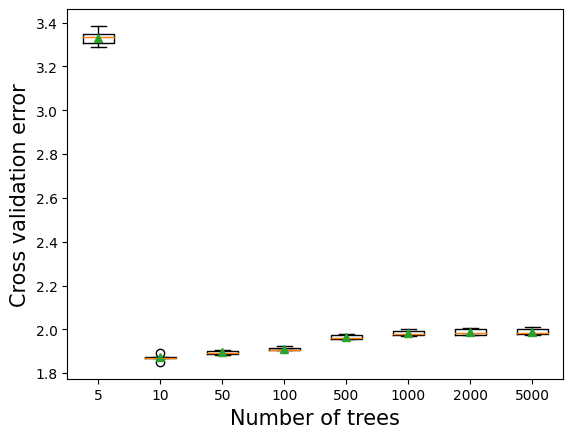

In [8]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Depth of the model

>1 1.892 (0.014)
>2 1.880 (0.016)
>3 1.882 (0.017)
>4 1.886 (0.018)
>5 1.894 (0.018)
>6 1.908 (0.019)
>7 1.928 (0.015)
>8 1.940 (0.017)
>9 1.950 (0.020)
>10 1.962 (0.016)
>11 1.968 (0.020)
>12 1.974 (0.021)
>13 1.979 (0.021)
>14 1.980 (0.018)
>15 1.981 (0.019)
>16 1.984 (0.018)
>17 1.988 (0.021)
>18 1.988 (0.022)
>19 1.984 (0.021)
>20 1.987 (0.018)


Text(0.5, 0, 'Depth of each tree')

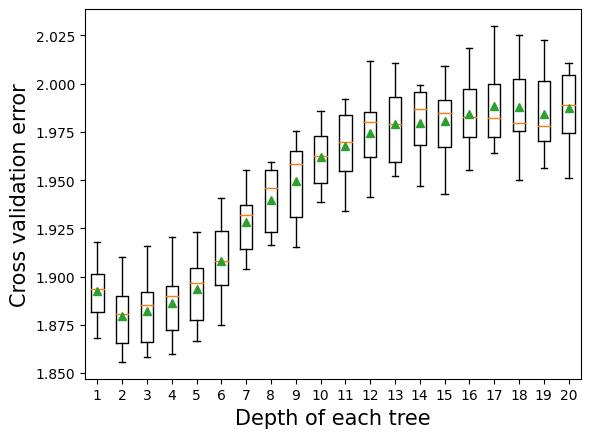

In [9]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate

>0.0100 12.9 (0.2)
>0.0500 1.9 (0.0)
>0.1000 1.9 (0.0)
>0.2000 1.9 (0.0)
>0.3000 1.9 (0.0)
>0.4000 1.9 (0.0)
>0.5000 2.0 (0.0)
>0.6000 2.0 (0.0)
>0.8000 2.1 (0.0)
>1.0000 2.2 (0.0)


Text(0.5, 0, 'Learning rate')

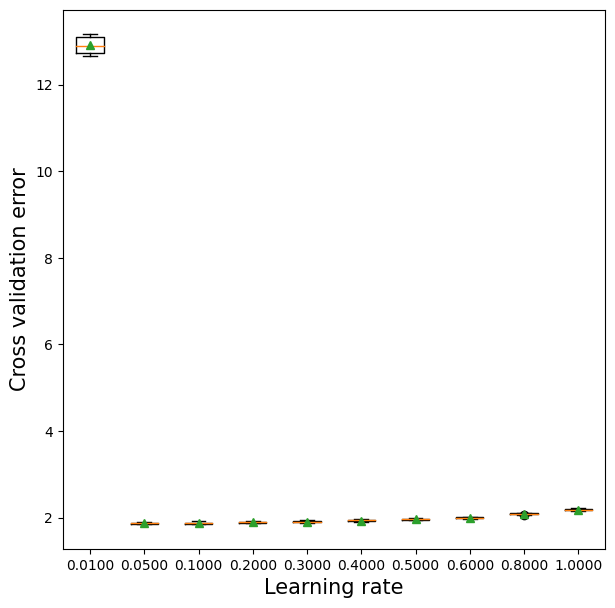

In [10]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Regularization

>0.0000 1.9 (0.0)
>0.5000 1.9 (0.0)
>1.0000 1.9 (0.0)
>1.5000 1.9 (0.0)
>2.0000 1.9 (0.0)
>10.0000 1.9 (0.0)
>100.0000 1.9 (0.0)


Text(0.5, 0, 'reg_lambda')

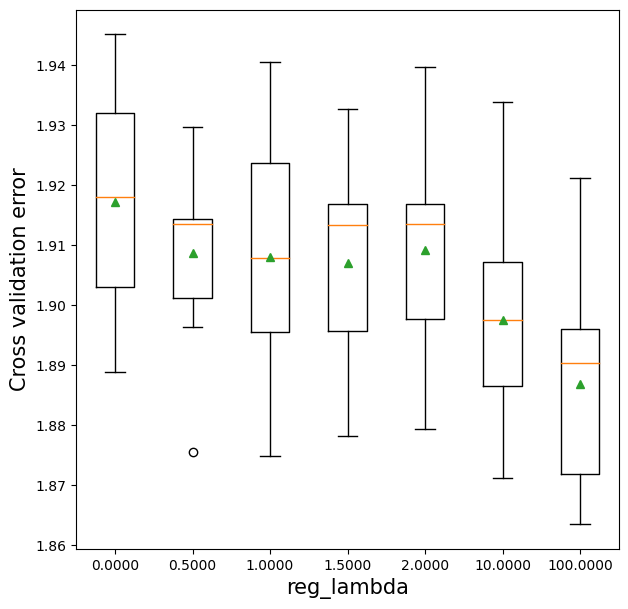

In [11]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>5.0000 1.9 (0.0)
>10.0000 1.9 (0.0)
>50.0000 1.9 (0.0)
>100.0000 1.9 (0.0)
>500.0000 1.9 (0.0)
>1000.0000 1.9 (0.0)
>5000.0000 1.9 (0.0)
>10000.0000 1.9 (0.0)
>50000.0000 1.9 (0.0)


Text(0.5, 0, 'reg_lambda')

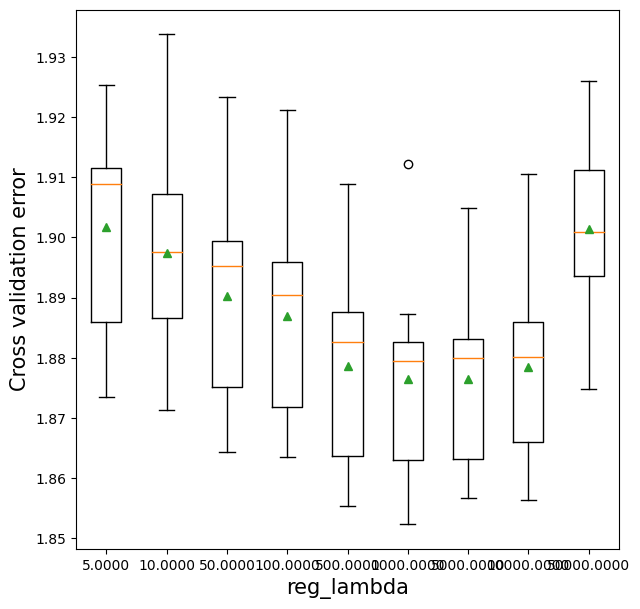

In [14]:
# Fine tune more general range for regularization
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [5,10,50,100,500,1000, 5000, 10000, 50000]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>500.0000 1.9 (0.0)
>750.0000 1.9 (0.0)
>1000.0000 1.9 (0.0)
>1250.0000 1.9 (0.0)
>1500.0000 1.9 (0.0)
>2000.0000 1.9 (0.0)
>2500.0000 1.9 (0.0)
>3000.0000 1.9 (0.0)
>4000.0000 1.9 (0.0)
>5000.0000 1.9 (0.0)


Text(0.5, 0, 'reg_lambda')

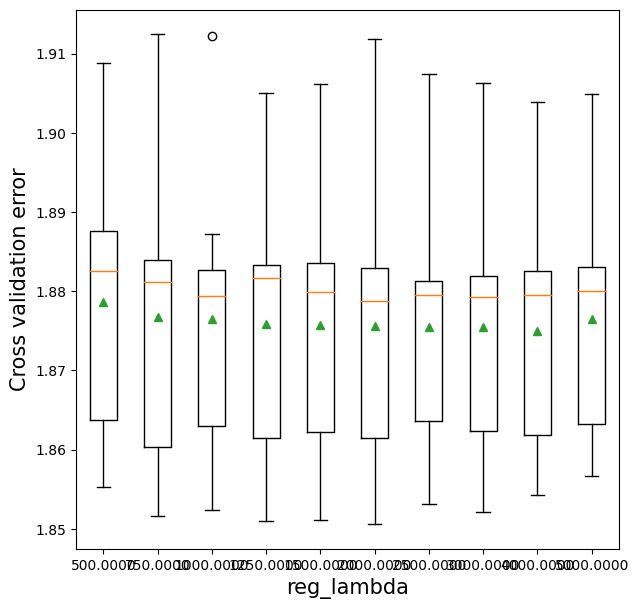

In [15]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 5000]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

### Regularization in gamma

>0.0000 1.9 (0.0)
>10.0000 1.9 (0.0)
>100.0000 1.9 (0.0)
>1000.0000 2.0 (0.0)
>10000.0000 2.0 (0.0)
>100000.0000 2.0 (0.0)
>1000000.0000 2.0 (0.0)
>10000000.0000 2.0 (0.0)
>100000000.0000 2.0 (0.0)
>1000000000.0000 2.0 (0.0)


Text(0.5, 0, 'gamma')

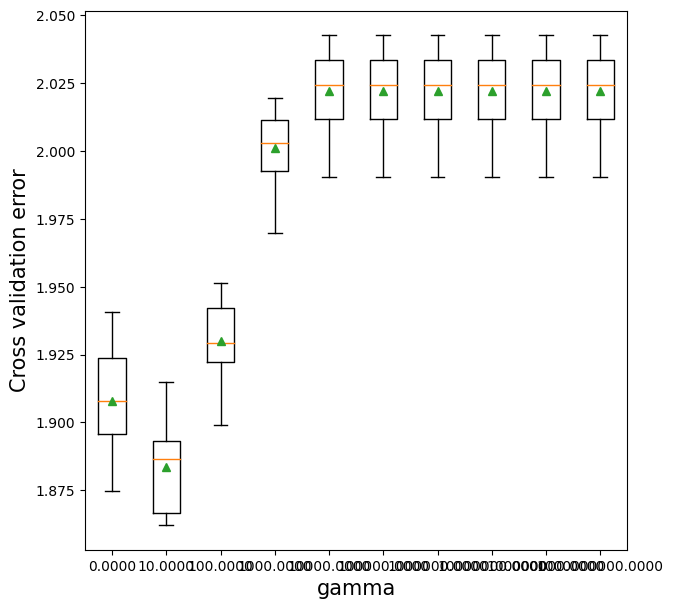

In [12]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, np.log(y_train))
    scores = np.exp(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

### Tuning full model with everything

In [20]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [2, 3, 4],
              'learning_rate': [0.05, 0.1, 0.2],
               'reg_lambda':[100, 500, 1000, 2000],
                'n_estimators':[50, 100, 500],
                'gamma': [5, 10, 20],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,np.log(y_train))
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 100, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.5}
Optimal cross validation R-squared =  0.16055439119071493
Time taken =  27  minutes


In [21]:
#K-fold cross validation to find optimal parameters for XGBoost
# Finer search
start_time = time.time()
param_grid = {'max_depth': [3, 4, 5],
              'learning_rate': [0.08, 0.1, 0.12, 0.14],
               'reg_lambda':[50, 100, 200, 250],
                'n_estimators':[100, 500, 1000],
                'gamma': [2, 3, 5, 9],
                'subsample': [0.7, 0.75, 0.80, 1],
                'colsample_bytree': [0.4, 0.5, 0.6, 1]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,np.log(y_train))
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1, 'reg_lambda': 200, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.12, 'gamma': 2, 'colsample_bytree': 0.5}
Optimal cross validation R-squared =  0.16259412911125098
Time taken =  75  minutes


In [29]:
model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.001,
                        n_estimators = 20000,reg_lambda = 100, gamma = 5, subsample = 0.75, colsample_bytree = 0.5, early_stopping_rounds = 250)
model.fit(X_train, y_train, eval_set = ([(X_test, y_test)]))

[0]	validation_0-rmse:8209.78734
[1]	validation_0-rmse:8208.33871
[2]	validation_0-rmse:8206.79883
[3]	validation_0-rmse:8205.38461
[4]	validation_0-rmse:8203.95035
[5]	validation_0-rmse:8202.45072
[6]	validation_0-rmse:8201.01564
[7]	validation_0-rmse:8199.60977
[8]	validation_0-rmse:8198.19039
[9]	validation_0-rmse:8196.69863
[10]	validation_0-rmse:8195.17227
[11]	validation_0-rmse:8193.66593
[12]	validation_0-rmse:8192.11573
[13]	validation_0-rmse:8190.60183
[14]	validation_0-rmse:8189.08032
[15]	validation_0-rmse:8187.68317
[16]	validation_0-rmse:8186.17156
[17]	validation_0-rmse:8184.58588
[18]	validation_0-rmse:8183.06826
[19]	validation_0-rmse:8181.58964
[20]	validation_0-rmse:8180.12418
[21]	validation_0-rmse:8178.77708
[22]	validation_0-rmse:8177.35842
[23]	validation_0-rmse:8175.87074
[24]	validation_0-rmse:8174.46071
[25]	validation_0-rmse:8173.09480
[26]	validation_0-rmse:8171.63403
[27]	validation_0-rmse:8170.14989
[28]	validation_0-rmse:8168.67760
[29]	validation_0-rmse:8

[238]	validation_0-rmse:7915.40354
[239]	validation_0-rmse:7914.45093
[240]	validation_0-rmse:7913.43865
[241]	validation_0-rmse:7912.40691
[242]	validation_0-rmse:7911.35568
[243]	validation_0-rmse:7910.44477
[244]	validation_0-rmse:7909.41965
[245]	validation_0-rmse:7908.44050
[246]	validation_0-rmse:7907.45094
[247]	validation_0-rmse:7906.42032
[248]	validation_0-rmse:7905.41101
[249]	validation_0-rmse:7904.47565
[250]	validation_0-rmse:7903.47156
[251]	validation_0-rmse:7902.50005
[252]	validation_0-rmse:7901.49372
[253]	validation_0-rmse:7900.45689
[254]	validation_0-rmse:7899.43786
[255]	validation_0-rmse:7898.51968
[256]	validation_0-rmse:7897.54404
[257]	validation_0-rmse:7896.56963
[258]	validation_0-rmse:7895.64504
[259]	validation_0-rmse:7894.67083
[260]	validation_0-rmse:7893.65214
[261]	validation_0-rmse:7892.72078
[262]	validation_0-rmse:7891.70695
[263]	validation_0-rmse:7890.71130
[264]	validation_0-rmse:7889.74542
[265]	validation_0-rmse:7888.82098
[266]	validation_0-r

[473]	validation_0-rmse:7721.62776
[474]	validation_0-rmse:7720.98070
[475]	validation_0-rmse:7720.30096
[476]	validation_0-rmse:7719.61334
[477]	validation_0-rmse:7718.92708
[478]	validation_0-rmse:7718.27325
[479]	validation_0-rmse:7717.59160
[480]	validation_0-rmse:7716.95191
[481]	validation_0-rmse:7716.31749
[482]	validation_0-rmse:7715.63783
[483]	validation_0-rmse:7714.98898
[484]	validation_0-rmse:7714.28986
[485]	validation_0-rmse:7713.61713
[486]	validation_0-rmse:7712.94164
[487]	validation_0-rmse:7712.28796
[488]	validation_0-rmse:7711.65698
[489]	validation_0-rmse:7711.02107
[490]	validation_0-rmse:7710.39957
[491]	validation_0-rmse:7709.77771
[492]	validation_0-rmse:7709.13562
[493]	validation_0-rmse:7708.49236
[494]	validation_0-rmse:7707.83208
[495]	validation_0-rmse:7707.18333
[496]	validation_0-rmse:7706.56054
[497]	validation_0-rmse:7705.90197
[498]	validation_0-rmse:7705.23651
[499]	validation_0-rmse:7704.55649
[500]	validation_0-rmse:7703.93633
[501]	validation_0-r

[708]	validation_0-rmse:7592.65029
[709]	validation_0-rmse:7592.18424
[710]	validation_0-rmse:7591.72492
[711]	validation_0-rmse:7591.28314
[712]	validation_0-rmse:7590.85399
[713]	validation_0-rmse:7590.41304
[714]	validation_0-rmse:7590.00840
[715]	validation_0-rmse:7589.59023
[716]	validation_0-rmse:7589.16327
[717]	validation_0-rmse:7588.73670
[718]	validation_0-rmse:7588.31974
[719]	validation_0-rmse:7587.85281
[720]	validation_0-rmse:7587.41814
[721]	validation_0-rmse:7587.01272
[722]	validation_0-rmse:7586.59549
[723]	validation_0-rmse:7586.13452
[724]	validation_0-rmse:7585.69295
[725]	validation_0-rmse:7585.25986
[726]	validation_0-rmse:7584.88238
[727]	validation_0-rmse:7584.47157
[728]	validation_0-rmse:7584.03948
[729]	validation_0-rmse:7583.60163
[730]	validation_0-rmse:7583.16479
[731]	validation_0-rmse:7582.72765
[732]	validation_0-rmse:7582.30979
[733]	validation_0-rmse:7581.88149
[734]	validation_0-rmse:7581.45375
[735]	validation_0-rmse:7581.06483
[736]	validation_0-r

[943]	validation_0-rmse:7507.17842
[944]	validation_0-rmse:7506.85706
[945]	validation_0-rmse:7506.54582
[946]	validation_0-rmse:7506.22940
[947]	validation_0-rmse:7505.90984
[948]	validation_0-rmse:7505.62504
[949]	validation_0-rmse:7505.33281
[950]	validation_0-rmse:7505.05650
[951]	validation_0-rmse:7504.76200
[952]	validation_0-rmse:7504.49054
[953]	validation_0-rmse:7504.16282
[954]	validation_0-rmse:7503.86978
[955]	validation_0-rmse:7503.56375
[956]	validation_0-rmse:7503.26877
[957]	validation_0-rmse:7502.95898
[958]	validation_0-rmse:7502.66853
[959]	validation_0-rmse:7502.34401
[960]	validation_0-rmse:7502.05342
[961]	validation_0-rmse:7501.75128
[962]	validation_0-rmse:7501.46828
[963]	validation_0-rmse:7501.21481
[964]	validation_0-rmse:7500.90906
[965]	validation_0-rmse:7500.58677
[966]	validation_0-rmse:7500.30514
[967]	validation_0-rmse:7500.03002
[968]	validation_0-rmse:7499.73783
[969]	validation_0-rmse:7499.46679
[970]	validation_0-rmse:7499.19760
[971]	validation_0-r

[1173]	validation_0-rmse:7451.52970
[1174]	validation_0-rmse:7451.31320
[1175]	validation_0-rmse:7451.12567
[1176]	validation_0-rmse:7450.90716
[1177]	validation_0-rmse:7450.70612
[1178]	validation_0-rmse:7450.50776
[1179]	validation_0-rmse:7450.29908
[1180]	validation_0-rmse:7450.05991
[1181]	validation_0-rmse:7449.86502
[1182]	validation_0-rmse:7449.66437
[1183]	validation_0-rmse:7449.47432
[1184]	validation_0-rmse:7449.26722
[1185]	validation_0-rmse:7449.08568
[1186]	validation_0-rmse:7448.87011
[1187]	validation_0-rmse:7448.69661
[1188]	validation_0-rmse:7448.48643
[1189]	validation_0-rmse:7448.29466
[1190]	validation_0-rmse:7448.13409
[1191]	validation_0-rmse:7447.96708
[1192]	validation_0-rmse:7447.77408
[1193]	validation_0-rmse:7447.57656
[1194]	validation_0-rmse:7447.38302
[1195]	validation_0-rmse:7447.17605
[1196]	validation_0-rmse:7446.97167
[1197]	validation_0-rmse:7446.77676
[1198]	validation_0-rmse:7446.60334
[1199]	validation_0-rmse:7446.41749
[1200]	validation_0-rmse:744

[1401]	validation_0-rmse:7414.03016
[1402]	validation_0-rmse:7413.89159
[1403]	validation_0-rmse:7413.74991
[1404]	validation_0-rmse:7413.61487
[1405]	validation_0-rmse:7413.48868
[1406]	validation_0-rmse:7413.37076
[1407]	validation_0-rmse:7413.22330
[1408]	validation_0-rmse:7413.09981
[1409]	validation_0-rmse:7412.98545
[1410]	validation_0-rmse:7412.85290
[1411]	validation_0-rmse:7412.72032
[1412]	validation_0-rmse:7412.59516
[1413]	validation_0-rmse:7412.47493
[1414]	validation_0-rmse:7412.33831
[1415]	validation_0-rmse:7412.19168
[1416]	validation_0-rmse:7412.05361
[1417]	validation_0-rmse:7411.92843
[1418]	validation_0-rmse:7411.79368
[1419]	validation_0-rmse:7411.68840
[1420]	validation_0-rmse:7411.55344
[1421]	validation_0-rmse:7411.41462
[1422]	validation_0-rmse:7411.29133
[1423]	validation_0-rmse:7411.17378
[1424]	validation_0-rmse:7411.05035
[1425]	validation_0-rmse:7410.93463
[1426]	validation_0-rmse:7410.79454
[1427]	validation_0-rmse:7410.66070
[1428]	validation_0-rmse:741

[1629]	validation_0-rmse:7388.44551
[1630]	validation_0-rmse:7388.35198
[1631]	validation_0-rmse:7388.25478
[1632]	validation_0-rmse:7388.13021
[1633]	validation_0-rmse:7388.03628
[1634]	validation_0-rmse:7387.94423
[1635]	validation_0-rmse:7387.83967
[1636]	validation_0-rmse:7387.75831
[1637]	validation_0-rmse:7387.65359
[1638]	validation_0-rmse:7387.54459
[1639]	validation_0-rmse:7387.45377
[1640]	validation_0-rmse:7387.35106
[1641]	validation_0-rmse:7387.24669
[1642]	validation_0-rmse:7387.15805
[1643]	validation_0-rmse:7387.07853
[1644]	validation_0-rmse:7386.99742
[1645]	validation_0-rmse:7386.90919
[1646]	validation_0-rmse:7386.82952
[1647]	validation_0-rmse:7386.73273
[1648]	validation_0-rmse:7386.62904
[1649]	validation_0-rmse:7386.56131
[1650]	validation_0-rmse:7386.48454
[1651]	validation_0-rmse:7386.37689
[1652]	validation_0-rmse:7386.27052
[1653]	validation_0-rmse:7386.17510
[1654]	validation_0-rmse:7386.08617
[1655]	validation_0-rmse:7386.00503
[1656]	validation_0-rmse:738

[1857]	validation_0-rmse:7371.43678
[1858]	validation_0-rmse:7371.35854
[1859]	validation_0-rmse:7371.28616
[1860]	validation_0-rmse:7371.21309
[1861]	validation_0-rmse:7371.15091
[1862]	validation_0-rmse:7371.09531
[1863]	validation_0-rmse:7371.04945
[1864]	validation_0-rmse:7370.97184
[1865]	validation_0-rmse:7370.91097
[1866]	validation_0-rmse:7370.85860
[1867]	validation_0-rmse:7370.77596
[1868]	validation_0-rmse:7370.70772
[1869]	validation_0-rmse:7370.64111
[1870]	validation_0-rmse:7370.59756
[1871]	validation_0-rmse:7370.54224
[1872]	validation_0-rmse:7370.47499
[1873]	validation_0-rmse:7370.40938
[1874]	validation_0-rmse:7370.36829
[1875]	validation_0-rmse:7370.31887
[1876]	validation_0-rmse:7370.26017
[1877]	validation_0-rmse:7370.18016
[1878]	validation_0-rmse:7370.10872
[1879]	validation_0-rmse:7370.04476
[1880]	validation_0-rmse:7369.98757
[1881]	validation_0-rmse:7369.92494
[1882]	validation_0-rmse:7369.86136
[1883]	validation_0-rmse:7369.80976
[1884]	validation_0-rmse:736

[2085]	validation_0-rmse:7359.58573
[2086]	validation_0-rmse:7359.54604
[2087]	validation_0-rmse:7359.48355
[2088]	validation_0-rmse:7359.44079
[2089]	validation_0-rmse:7359.39785
[2090]	validation_0-rmse:7359.33697
[2091]	validation_0-rmse:7359.29998
[2092]	validation_0-rmse:7359.27091
[2093]	validation_0-rmse:7359.21955
[2094]	validation_0-rmse:7359.17472
[2095]	validation_0-rmse:7359.12870
[2096]	validation_0-rmse:7359.08886
[2097]	validation_0-rmse:7359.04809
[2098]	validation_0-rmse:7359.01410
[2099]	validation_0-rmse:7358.97204
[2100]	validation_0-rmse:7358.94730
[2101]	validation_0-rmse:7358.89846
[2102]	validation_0-rmse:7358.86817
[2103]	validation_0-rmse:7358.83786
[2104]	validation_0-rmse:7358.81453
[2105]	validation_0-rmse:7358.76928
[2106]	validation_0-rmse:7358.71991
[2107]	validation_0-rmse:7358.67178
[2108]	validation_0-rmse:7358.62382
[2109]	validation_0-rmse:7358.57957
[2110]	validation_0-rmse:7358.53846
[2111]	validation_0-rmse:7358.49561
[2112]	validation_0-rmse:735

[2313]	validation_0-rmse:7351.24534
[2314]	validation_0-rmse:7351.23312
[2315]	validation_0-rmse:7351.19745
[2316]	validation_0-rmse:7351.14832
[2317]	validation_0-rmse:7351.12755
[2318]	validation_0-rmse:7351.07279
[2319]	validation_0-rmse:7351.04387
[2320]	validation_0-rmse:7351.01126
[2321]	validation_0-rmse:7350.98357
[2322]	validation_0-rmse:7350.98059
[2323]	validation_0-rmse:7350.95380
[2324]	validation_0-rmse:7350.90218
[2325]	validation_0-rmse:7350.87454
[2326]	validation_0-rmse:7350.84410
[2327]	validation_0-rmse:7350.81598
[2328]	validation_0-rmse:7350.79233
[2329]	validation_0-rmse:7350.73734
[2330]	validation_0-rmse:7350.69186
[2331]	validation_0-rmse:7350.65435
[2332]	validation_0-rmse:7350.62995
[2333]	validation_0-rmse:7350.58774
[2334]	validation_0-rmse:7350.55184
[2335]	validation_0-rmse:7350.51561
[2336]	validation_0-rmse:7350.47889
[2337]	validation_0-rmse:7350.46380
[2338]	validation_0-rmse:7350.43650
[2339]	validation_0-rmse:7350.39791
[2340]	validation_0-rmse:735

[2541]	validation_0-rmse:7345.52917
[2542]	validation_0-rmse:7345.51440
[2543]	validation_0-rmse:7345.50097
[2544]	validation_0-rmse:7345.48464
[2545]	validation_0-rmse:7345.47916
[2546]	validation_0-rmse:7345.44629
[2547]	validation_0-rmse:7345.40878
[2548]	validation_0-rmse:7345.40003
[2549]	validation_0-rmse:7345.38262
[2550]	validation_0-rmse:7345.35971
[2551]	validation_0-rmse:7345.35246
[2552]	validation_0-rmse:7345.32454
[2553]	validation_0-rmse:7345.28941
[2554]	validation_0-rmse:7345.27472
[2555]	validation_0-rmse:7345.25512
[2556]	validation_0-rmse:7345.23792
[2557]	validation_0-rmse:7345.22147
[2558]	validation_0-rmse:7345.20474
[2559]	validation_0-rmse:7345.18130
[2560]	validation_0-rmse:7345.15207
[2561]	validation_0-rmse:7345.12325
[2562]	validation_0-rmse:7345.07471
[2563]	validation_0-rmse:7345.05456
[2564]	validation_0-rmse:7345.02255
[2565]	validation_0-rmse:7345.01008
[2566]	validation_0-rmse:7344.97315
[2567]	validation_0-rmse:7344.93329
[2568]	validation_0-rmse:734

[2769]	validation_0-rmse:7341.58637
[2770]	validation_0-rmse:7341.56543
[2771]	validation_0-rmse:7341.55185
[2772]	validation_0-rmse:7341.52839
[2773]	validation_0-rmse:7341.51380
[2774]	validation_0-rmse:7341.48874
[2775]	validation_0-rmse:7341.46364
[2776]	validation_0-rmse:7341.45237
[2777]	validation_0-rmse:7341.44034
[2778]	validation_0-rmse:7341.42892
[2779]	validation_0-rmse:7341.40860
[2780]	validation_0-rmse:7341.38757
[2781]	validation_0-rmse:7341.38854
[2782]	validation_0-rmse:7341.38315
[2783]	validation_0-rmse:7341.37805
[2784]	validation_0-rmse:7341.36141
[2785]	validation_0-rmse:7341.34872
[2786]	validation_0-rmse:7341.33503
[2787]	validation_0-rmse:7341.32524
[2788]	validation_0-rmse:7341.31454
[2789]	validation_0-rmse:7341.29857
[2790]	validation_0-rmse:7341.28567
[2791]	validation_0-rmse:7341.26799
[2792]	validation_0-rmse:7341.26336
[2793]	validation_0-rmse:7341.25923
[2794]	validation_0-rmse:7341.25535
[2795]	validation_0-rmse:7341.22906
[2796]	validation_0-rmse:734

[2997]	validation_0-rmse:7339.12267
[2998]	validation_0-rmse:7339.11749
[2999]	validation_0-rmse:7339.10725
[3000]	validation_0-rmse:7339.10372
[3001]	validation_0-rmse:7339.10243
[3002]	validation_0-rmse:7339.10745
[3003]	validation_0-rmse:7339.10313
[3004]	validation_0-rmse:7339.09980
[3005]	validation_0-rmse:7339.08348
[3006]	validation_0-rmse:7339.06946
[3007]	validation_0-rmse:7339.06453
[3008]	validation_0-rmse:7339.06434
[3009]	validation_0-rmse:7339.04783
[3010]	validation_0-rmse:7339.03646
[3011]	validation_0-rmse:7339.02919
[3012]	validation_0-rmse:7339.01863
[3013]	validation_0-rmse:7339.00777
[3014]	validation_0-rmse:7338.98342
[3015]	validation_0-rmse:7338.98028
[3016]	validation_0-rmse:7338.98186
[3017]	validation_0-rmse:7338.95230
[3018]	validation_0-rmse:7338.94444
[3019]	validation_0-rmse:7338.94828
[3020]	validation_0-rmse:7338.94953
[3021]	validation_0-rmse:7338.93357
[3022]	validation_0-rmse:7338.92611
[3023]	validation_0-rmse:7338.91357
[3024]	validation_0-rmse:733

[3225]	validation_0-rmse:7337.35494
[3226]	validation_0-rmse:7337.34881
[3227]	validation_0-rmse:7337.34016
[3228]	validation_0-rmse:7337.35372
[3229]	validation_0-rmse:7337.33486
[3230]	validation_0-rmse:7337.33309
[3231]	validation_0-rmse:7337.32334
[3232]	validation_0-rmse:7337.31420
[3233]	validation_0-rmse:7337.31268
[3234]	validation_0-rmse:7337.32296
[3235]	validation_0-rmse:7337.31762
[3236]	validation_0-rmse:7337.30612
[3237]	validation_0-rmse:7337.28306
[3238]	validation_0-rmse:7337.25703
[3239]	validation_0-rmse:7337.24734
[3240]	validation_0-rmse:7337.24574
[3241]	validation_0-rmse:7337.24995
[3242]	validation_0-rmse:7337.23872
[3243]	validation_0-rmse:7337.22255
[3244]	validation_0-rmse:7337.21750
[3245]	validation_0-rmse:7337.20460
[3246]	validation_0-rmse:7337.19632
[3247]	validation_0-rmse:7337.20201
[3248]	validation_0-rmse:7337.21037
[3249]	validation_0-rmse:7337.19441
[3250]	validation_0-rmse:7337.19127
[3251]	validation_0-rmse:7337.20472
[3252]	validation_0-rmse:733

[3453]	validation_0-rmse:7336.28982
[3454]	validation_0-rmse:7336.28759
[3455]	validation_0-rmse:7336.28372
[3456]	validation_0-rmse:7336.29039
[3457]	validation_0-rmse:7336.27980
[3458]	validation_0-rmse:7336.28739
[3459]	validation_0-rmse:7336.27557
[3460]	validation_0-rmse:7336.27887
[3461]	validation_0-rmse:7336.27981
[3462]	validation_0-rmse:7336.29157
[3463]	validation_0-rmse:7336.29792
[3464]	validation_0-rmse:7336.28995
[3465]	validation_0-rmse:7336.28194
[3466]	validation_0-rmse:7336.27713
[3467]	validation_0-rmse:7336.27436
[3468]	validation_0-rmse:7336.27022
[3469]	validation_0-rmse:7336.27106
[3470]	validation_0-rmse:7336.25352
[3471]	validation_0-rmse:7336.24855
[3472]	validation_0-rmse:7336.25073
[3473]	validation_0-rmse:7336.24646
[3474]	validation_0-rmse:7336.24242
[3475]	validation_0-rmse:7336.23333
[3476]	validation_0-rmse:7336.23634
[3477]	validation_0-rmse:7336.22866
[3478]	validation_0-rmse:7336.21743
[3479]	validation_0-rmse:7336.21563
[3480]	validation_0-rmse:733

[3681]	validation_0-rmse:7335.52159
[3682]	validation_0-rmse:7335.53002
[3683]	validation_0-rmse:7335.51580
[3684]	validation_0-rmse:7335.51195
[3685]	validation_0-rmse:7335.49048
[3686]	validation_0-rmse:7335.49654
[3687]	validation_0-rmse:7335.50407
[3688]	validation_0-rmse:7335.50339
[3689]	validation_0-rmse:7335.49518
[3690]	validation_0-rmse:7335.49899
[3691]	validation_0-rmse:7335.48060
[3692]	validation_0-rmse:7335.47092
[3693]	validation_0-rmse:7335.45791
[3694]	validation_0-rmse:7335.45276
[3695]	validation_0-rmse:7335.44434
[3696]	validation_0-rmse:7335.43054
[3697]	validation_0-rmse:7335.40398
[3698]	validation_0-rmse:7335.39751
[3699]	validation_0-rmse:7335.40148
[3700]	validation_0-rmse:7335.40941
[3701]	validation_0-rmse:7335.39150
[3702]	validation_0-rmse:7335.40839
[3703]	validation_0-rmse:7335.40754
[3704]	validation_0-rmse:7335.41310
[3705]	validation_0-rmse:7335.40828
[3706]	validation_0-rmse:7335.40517
[3707]	validation_0-rmse:7335.42080
[3708]	validation_0-rmse:733

[3909]	validation_0-rmse:7335.04483
[3910]	validation_0-rmse:7335.04822
[3911]	validation_0-rmse:7335.05096
[3912]	validation_0-rmse:7335.05296
[3913]	validation_0-rmse:7335.05637
[3914]	validation_0-rmse:7335.05628
[3915]	validation_0-rmse:7335.06160
[3916]	validation_0-rmse:7335.05285
[3917]	validation_0-rmse:7335.05793
[3918]	validation_0-rmse:7335.05980
[3919]	validation_0-rmse:7335.05231
[3920]	validation_0-rmse:7335.04636
[3921]	validation_0-rmse:7335.03772
[3922]	validation_0-rmse:7335.03468
[3923]	validation_0-rmse:7335.04804
[3924]	validation_0-rmse:7335.05396
[3925]	validation_0-rmse:7335.04933
[3926]	validation_0-rmse:7335.03554
[3927]	validation_0-rmse:7335.03103
[3928]	validation_0-rmse:7335.02238
[3929]	validation_0-rmse:7335.03072
[3930]	validation_0-rmse:7335.04942
[3931]	validation_0-rmse:7335.05457
[3932]	validation_0-rmse:7335.04620
[3933]	validation_0-rmse:7335.04727
[3934]	validation_0-rmse:7335.03800
[3935]	validation_0-rmse:7335.02187
[3936]	validation_0-rmse:733

[4137]	validation_0-rmse:7334.78830
[4138]	validation_0-rmse:7334.78764
[4139]	validation_0-rmse:7334.79419
[4140]	validation_0-rmse:7334.77573
[4141]	validation_0-rmse:7334.77375
[4142]	validation_0-rmse:7334.76798
[4143]	validation_0-rmse:7334.77013
[4144]	validation_0-rmse:7334.76478
[4145]	validation_0-rmse:7334.76478
[4146]	validation_0-rmse:7334.76312
[4147]	validation_0-rmse:7334.76979
[4148]	validation_0-rmse:7334.75819
[4149]	validation_0-rmse:7334.72747
[4150]	validation_0-rmse:7334.72467
[4151]	validation_0-rmse:7334.72590
[4152]	validation_0-rmse:7334.71990
[4153]	validation_0-rmse:7334.74286
[4154]	validation_0-rmse:7334.73147
[4155]	validation_0-rmse:7334.73519
[4156]	validation_0-rmse:7334.73180
[4157]	validation_0-rmse:7334.73369
[4158]	validation_0-rmse:7334.73684
[4159]	validation_0-rmse:7334.74385
[4160]	validation_0-rmse:7334.74138
[4161]	validation_0-rmse:7334.74255
[4162]	validation_0-rmse:7334.74206
[4163]	validation_0-rmse:7334.72976
[4164]	validation_0-rmse:733

[4365]	validation_0-rmse:7334.75213
[4366]	validation_0-rmse:7334.76185
[4367]	validation_0-rmse:7334.77105
[4368]	validation_0-rmse:7334.77722
[4369]	validation_0-rmse:7334.79069
[4370]	validation_0-rmse:7334.77992
[4371]	validation_0-rmse:7334.78147
[4372]	validation_0-rmse:7334.77467
[4373]	validation_0-rmse:7334.77090
[4374]	validation_0-rmse:7334.77131
[4375]	validation_0-rmse:7334.75201
[4376]	validation_0-rmse:7334.75474
[4377]	validation_0-rmse:7334.75260
[4378]	validation_0-rmse:7334.76195
[4379]	validation_0-rmse:7334.75190
[4380]	validation_0-rmse:7334.75310
[4381]	validation_0-rmse:7334.75982
[4382]	validation_0-rmse:7334.75848
[4383]	validation_0-rmse:7334.76132
[4384]	validation_0-rmse:7334.76440
[4385]	validation_0-rmse:7334.77527
[4386]	validation_0-rmse:7334.76608
[4387]	validation_0-rmse:7334.75985
[4388]	validation_0-rmse:7334.76151
[4389]	validation_0-rmse:7334.74987
[4390]	validation_0-rmse:7334.77068
[4391]	validation_0-rmse:7334.77097
[4392]	validation_0-rmse:733

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=250,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [30]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_test, model.predict(X_test))))

XGBoost MAE is 2819.469302557143


In [27]:
model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.001,
                        n_estimators = 20000,reg_lambda = 200, gamma = 2, subsample = 1, colsample_bytree = 0.5, early_stopping_rounds = 250)
model.fit(X_train, y_train, eval_set = ([(X_test, y_test)]))

[0]	validation_0-rmse:8209.83863
[1]	validation_0-rmse:8208.37944
[2]	validation_0-rmse:8206.93519
[3]	validation_0-rmse:8205.46474
[4]	validation_0-rmse:8203.92908
[5]	validation_0-rmse:8202.46552
[6]	validation_0-rmse:8201.02365
[7]	validation_0-rmse:8199.49399
[8]	validation_0-rmse:8197.97636
[9]	validation_0-rmse:8196.47308
[10]	validation_0-rmse:8194.97505
[11]	validation_0-rmse:8193.45698
[12]	validation_0-rmse:8191.96341
[13]	validation_0-rmse:8190.52916
[14]	validation_0-rmse:8189.05478
[15]	validation_0-rmse:8187.54469
[16]	validation_0-rmse:8186.07007
[17]	validation_0-rmse:8184.67133
[18]	validation_0-rmse:8183.25575
[19]	validation_0-rmse:8181.84447
[20]	validation_0-rmse:8180.45119
[21]	validation_0-rmse:8179.05647
[22]	validation_0-rmse:8177.64483
[23]	validation_0-rmse:8176.18328
[24]	validation_0-rmse:8174.72279
[25]	validation_0-rmse:8173.33634
[26]	validation_0-rmse:8171.92569
[27]	validation_0-rmse:8170.48934
[28]	validation_0-rmse:8169.11995
[29]	validation_0-rmse:8

[238]	validation_0-rmse:7917.30050
[239]	validation_0-rmse:7916.28846
[240]	validation_0-rmse:7915.26184
[241]	validation_0-rmse:7914.31906
[242]	validation_0-rmse:7913.26907
[243]	validation_0-rmse:7912.27271
[244]	validation_0-rmse:7911.29034
[245]	validation_0-rmse:7910.31573
[246]	validation_0-rmse:7909.31417
[247]	validation_0-rmse:7908.35466
[248]	validation_0-rmse:7907.35736
[249]	validation_0-rmse:7906.40377
[250]	validation_0-rmse:7905.41079
[251]	validation_0-rmse:7904.42313
[252]	validation_0-rmse:7903.49861
[253]	validation_0-rmse:7902.57001
[254]	validation_0-rmse:7901.57127
[255]	validation_0-rmse:7900.58424
[256]	validation_0-rmse:7899.62842
[257]	validation_0-rmse:7898.70715
[258]	validation_0-rmse:7897.70174
[259]	validation_0-rmse:7896.70329
[260]	validation_0-rmse:7895.75556
[261]	validation_0-rmse:7894.76710
[262]	validation_0-rmse:7893.79594
[263]	validation_0-rmse:7892.83741
[264]	validation_0-rmse:7891.86177
[265]	validation_0-rmse:7890.87646
[266]	validation_0-r

[473]	validation_0-rmse:7723.66070
[474]	validation_0-rmse:7723.04039
[475]	validation_0-rmse:7722.42927
[476]	validation_0-rmse:7721.80637
[477]	validation_0-rmse:7721.18058
[478]	validation_0-rmse:7720.47659
[479]	validation_0-rmse:7719.80982
[480]	validation_0-rmse:7719.18792
[481]	validation_0-rmse:7718.53256
[482]	validation_0-rmse:7717.90666
[483]	validation_0-rmse:7717.22461
[484]	validation_0-rmse:7716.53484
[485]	validation_0-rmse:7715.89591
[486]	validation_0-rmse:7715.23076
[487]	validation_0-rmse:7714.57379
[488]	validation_0-rmse:7713.91980
[489]	validation_0-rmse:7713.25965
[490]	validation_0-rmse:7712.64591
[491]	validation_0-rmse:7712.00308
[492]	validation_0-rmse:7711.37468
[493]	validation_0-rmse:7710.75743
[494]	validation_0-rmse:7710.10321
[495]	validation_0-rmse:7709.48814
[496]	validation_0-rmse:7708.87618
[497]	validation_0-rmse:7708.25692
[498]	validation_0-rmse:7707.61412
[499]	validation_0-rmse:7706.96725
[500]	validation_0-rmse:7706.36494
[501]	validation_0-r

[708]	validation_0-rmse:7595.60427
[709]	validation_0-rmse:7595.16242
[710]	validation_0-rmse:7594.72761
[711]	validation_0-rmse:7594.28293
[712]	validation_0-rmse:7593.83372
[713]	validation_0-rmse:7593.37276
[714]	validation_0-rmse:7592.95482
[715]	validation_0-rmse:7592.53327
[716]	validation_0-rmse:7592.06192
[717]	validation_0-rmse:7591.62762
[718]	validation_0-rmse:7591.15906
[719]	validation_0-rmse:7590.70285
[720]	validation_0-rmse:7590.27852
[721]	validation_0-rmse:7589.84607
[722]	validation_0-rmse:7589.40016
[723]	validation_0-rmse:7588.95471
[724]	validation_0-rmse:7588.53978
[725]	validation_0-rmse:7588.10245
[726]	validation_0-rmse:7587.68004
[727]	validation_0-rmse:7587.24634
[728]	validation_0-rmse:7586.79034
[729]	validation_0-rmse:7586.37606
[730]	validation_0-rmse:7585.91588
[731]	validation_0-rmse:7585.48880
[732]	validation_0-rmse:7585.06038
[733]	validation_0-rmse:7584.62826
[734]	validation_0-rmse:7584.18470
[735]	validation_0-rmse:7583.75470
[736]	validation_0-r

[943]	validation_0-rmse:7509.98416
[944]	validation_0-rmse:7509.70465
[945]	validation_0-rmse:7509.44513
[946]	validation_0-rmse:7509.12024
[947]	validation_0-rmse:7508.83203
[948]	validation_0-rmse:7508.52060
[949]	validation_0-rmse:7508.23254
[950]	validation_0-rmse:7507.93259
[951]	validation_0-rmse:7507.64278
[952]	validation_0-rmse:7507.34183
[953]	validation_0-rmse:7507.03520
[954]	validation_0-rmse:7506.72803
[955]	validation_0-rmse:7506.43027
[956]	validation_0-rmse:7506.15594
[957]	validation_0-rmse:7505.84930
[958]	validation_0-rmse:7505.55553
[959]	validation_0-rmse:7505.23439
[960]	validation_0-rmse:7504.93817
[961]	validation_0-rmse:7504.63737
[962]	validation_0-rmse:7504.35187
[963]	validation_0-rmse:7504.08098
[964]	validation_0-rmse:7503.82739
[965]	validation_0-rmse:7503.55135
[966]	validation_0-rmse:7503.26503
[967]	validation_0-rmse:7503.01601
[968]	validation_0-rmse:7502.72728
[969]	validation_0-rmse:7502.46123
[970]	validation_0-rmse:7502.17219
[971]	validation_0-r

[1173]	validation_0-rmse:7454.24088
[1174]	validation_0-rmse:7454.04831
[1175]	validation_0-rmse:7453.85492
[1176]	validation_0-rmse:7453.66377
[1177]	validation_0-rmse:7453.45318
[1178]	validation_0-rmse:7453.25629
[1179]	validation_0-rmse:7453.04543
[1180]	validation_0-rmse:7452.86830
[1181]	validation_0-rmse:7452.68633
[1182]	validation_0-rmse:7452.49743
[1183]	validation_0-rmse:7452.30415
[1184]	validation_0-rmse:7452.10461
[1185]	validation_0-rmse:7451.91543
[1186]	validation_0-rmse:7451.72045
[1187]	validation_0-rmse:7451.51396
[1188]	validation_0-rmse:7451.30698
[1189]	validation_0-rmse:7451.09312
[1190]	validation_0-rmse:7450.89137
[1191]	validation_0-rmse:7450.69204
[1192]	validation_0-rmse:7450.51159
[1193]	validation_0-rmse:7450.32173
[1194]	validation_0-rmse:7450.12586
[1195]	validation_0-rmse:7449.93508
[1196]	validation_0-rmse:7449.75155
[1197]	validation_0-rmse:7449.58152
[1198]	validation_0-rmse:7449.37977
[1199]	validation_0-rmse:7449.19411
[1200]	validation_0-rmse:744

[1401]	validation_0-rmse:7416.49476
[1402]	validation_0-rmse:7416.37496
[1403]	validation_0-rmse:7416.25654
[1404]	validation_0-rmse:7416.10721
[1405]	validation_0-rmse:7415.97483
[1406]	validation_0-rmse:7415.81256
[1407]	validation_0-rmse:7415.65458
[1408]	validation_0-rmse:7415.53150
[1409]	validation_0-rmse:7415.37534
[1410]	validation_0-rmse:7415.22428
[1411]	validation_0-rmse:7415.08092
[1412]	validation_0-rmse:7414.95883
[1413]	validation_0-rmse:7414.81489
[1414]	validation_0-rmse:7414.68911
[1415]	validation_0-rmse:7414.54985
[1416]	validation_0-rmse:7414.40942
[1417]	validation_0-rmse:7414.26452
[1418]	validation_0-rmse:7414.14572
[1419]	validation_0-rmse:7414.01322
[1420]	validation_0-rmse:7413.87183
[1421]	validation_0-rmse:7413.73367
[1422]	validation_0-rmse:7413.61838
[1423]	validation_0-rmse:7413.52140
[1424]	validation_0-rmse:7413.37489
[1425]	validation_0-rmse:7413.23145
[1426]	validation_0-rmse:7413.09901
[1427]	validation_0-rmse:7412.99537
[1428]	validation_0-rmse:741

[1629]	validation_0-rmse:7390.91073
[1630]	validation_0-rmse:7390.81208
[1631]	validation_0-rmse:7390.74372
[1632]	validation_0-rmse:7390.64030
[1633]	validation_0-rmse:7390.55180
[1634]	validation_0-rmse:7390.44795
[1635]	validation_0-rmse:7390.35692
[1636]	validation_0-rmse:7390.26971
[1637]	validation_0-rmse:7390.18335
[1638]	validation_0-rmse:7390.09229
[1639]	validation_0-rmse:7390.00327
[1640]	validation_0-rmse:7389.89294
[1641]	validation_0-rmse:7389.79054
[1642]	validation_0-rmse:7389.69078
[1643]	validation_0-rmse:7389.61412
[1644]	validation_0-rmse:7389.53185
[1645]	validation_0-rmse:7389.43581
[1646]	validation_0-rmse:7389.34983
[1647]	validation_0-rmse:7389.26172
[1648]	validation_0-rmse:7389.18986
[1649]	validation_0-rmse:7389.08463
[1650]	validation_0-rmse:7388.96608
[1651]	validation_0-rmse:7388.85852
[1652]	validation_0-rmse:7388.76768
[1653]	validation_0-rmse:7388.66728
[1654]	validation_0-rmse:7388.56864
[1655]	validation_0-rmse:7388.47962
[1656]	validation_0-rmse:738

[1857]	validation_0-rmse:7373.62861
[1858]	validation_0-rmse:7373.58564
[1859]	validation_0-rmse:7373.51857
[1860]	validation_0-rmse:7373.45877
[1861]	validation_0-rmse:7373.38553
[1862]	validation_0-rmse:7373.32251
[1863]	validation_0-rmse:7373.29042
[1864]	validation_0-rmse:7373.22047
[1865]	validation_0-rmse:7373.15885
[1866]	validation_0-rmse:7373.11359
[1867]	validation_0-rmse:7373.06112
[1868]	validation_0-rmse:7373.00140
[1869]	validation_0-rmse:7372.92169
[1870]	validation_0-rmse:7372.86391
[1871]	validation_0-rmse:7372.79953
[1872]	validation_0-rmse:7372.73687
[1873]	validation_0-rmse:7372.66801
[1874]	validation_0-rmse:7372.60723
[1875]	validation_0-rmse:7372.53575
[1876]	validation_0-rmse:7372.45803
[1877]	validation_0-rmse:7372.39395
[1878]	validation_0-rmse:7372.34279
[1879]	validation_0-rmse:7372.26634
[1880]	validation_0-rmse:7372.21354
[1881]	validation_0-rmse:7372.17793
[1882]	validation_0-rmse:7372.13192
[1883]	validation_0-rmse:7372.08335
[1884]	validation_0-rmse:737

[2085]	validation_0-rmse:7361.67063
[2086]	validation_0-rmse:7361.64134
[2087]	validation_0-rmse:7361.60287
[2088]	validation_0-rmse:7361.56431
[2089]	validation_0-rmse:7361.50320
[2090]	validation_0-rmse:7361.46820
[2091]	validation_0-rmse:7361.41183
[2092]	validation_0-rmse:7361.37032
[2093]	validation_0-rmse:7361.32869
[2094]	validation_0-rmse:7361.29163
[2095]	validation_0-rmse:7361.24997
[2096]	validation_0-rmse:7361.20350
[2097]	validation_0-rmse:7361.15709
[2098]	validation_0-rmse:7361.10860
[2099]	validation_0-rmse:7361.06596
[2100]	validation_0-rmse:7361.03859
[2101]	validation_0-rmse:7360.99216
[2102]	validation_0-rmse:7360.94329
[2103]	validation_0-rmse:7360.90169
[2104]	validation_0-rmse:7360.85219
[2105]	validation_0-rmse:7360.81032
[2106]	validation_0-rmse:7360.78335
[2107]	validation_0-rmse:7360.74910
[2108]	validation_0-rmse:7360.68505
[2109]	validation_0-rmse:7360.63974
[2110]	validation_0-rmse:7360.60301
[2111]	validation_0-rmse:7360.56011
[2112]	validation_0-rmse:736

[2312]	validation_0-rmse:7353.55605
[2313]	validation_0-rmse:7353.52645
[2314]	validation_0-rmse:7353.49161
[2315]	validation_0-rmse:7353.46035
[2316]	validation_0-rmse:7353.42347
[2317]	validation_0-rmse:7353.38528
[2318]	validation_0-rmse:7353.34435
[2319]	validation_0-rmse:7353.31765
[2320]	validation_0-rmse:7353.28466
[2321]	validation_0-rmse:7353.25529
[2322]	validation_0-rmse:7353.20437
[2323]	validation_0-rmse:7353.18569
[2324]	validation_0-rmse:7353.15644
[2325]	validation_0-rmse:7353.12890
[2326]	validation_0-rmse:7353.07331
[2327]	validation_0-rmse:7353.03756
[2328]	validation_0-rmse:7352.99675
[2329]	validation_0-rmse:7352.97565
[2330]	validation_0-rmse:7352.94251
[2331]	validation_0-rmse:7352.90995
[2332]	validation_0-rmse:7352.86850
[2333]	validation_0-rmse:7352.83174
[2334]	validation_0-rmse:7352.79465
[2335]	validation_0-rmse:7352.75977
[2336]	validation_0-rmse:7352.73212
[2337]	validation_0-rmse:7352.69390
[2338]	validation_0-rmse:7352.66579
[2339]	validation_0-rmse:735

[2540]	validation_0-rmse:7347.74965
[2541]	validation_0-rmse:7347.73176
[2542]	validation_0-rmse:7347.70540
[2543]	validation_0-rmse:7347.69178
[2544]	validation_0-rmse:7347.67880
[2545]	validation_0-rmse:7347.66362
[2546]	validation_0-rmse:7347.65246
[2547]	validation_0-rmse:7347.61856
[2548]	validation_0-rmse:7347.61482
[2549]	validation_0-rmse:7347.60195
[2550]	validation_0-rmse:7347.58754
[2551]	validation_0-rmse:7347.57588
[2552]	validation_0-rmse:7347.56349
[2553]	validation_0-rmse:7347.55121
[2554]	validation_0-rmse:7347.51557
[2555]	validation_0-rmse:7347.49545
[2556]	validation_0-rmse:7347.47375
[2557]	validation_0-rmse:7347.46304
[2558]	validation_0-rmse:7347.43540
[2559]	validation_0-rmse:7347.41486
[2560]	validation_0-rmse:7347.38694
[2561]	validation_0-rmse:7347.35940
[2562]	validation_0-rmse:7347.33737
[2563]	validation_0-rmse:7347.31909
[2564]	validation_0-rmse:7347.29345
[2565]	validation_0-rmse:7347.27310
[2566]	validation_0-rmse:7347.25047
[2567]	validation_0-rmse:734

[2768]	validation_0-rmse:7343.91576
[2769]	validation_0-rmse:7343.90439
[2770]	validation_0-rmse:7343.88316
[2771]	validation_0-rmse:7343.85890
[2772]	validation_0-rmse:7343.85927
[2773]	validation_0-rmse:7343.85550
[2774]	validation_0-rmse:7343.83931
[2775]	validation_0-rmse:7343.82230
[2776]	validation_0-rmse:7343.81231
[2777]	validation_0-rmse:7343.80167
[2778]	validation_0-rmse:7343.79021
[2779]	validation_0-rmse:7343.78280
[2780]	validation_0-rmse:7343.77993
[2781]	validation_0-rmse:7343.76816
[2782]	validation_0-rmse:7343.76088
[2783]	validation_0-rmse:7343.73845
[2784]	validation_0-rmse:7343.73399
[2785]	validation_0-rmse:7343.73328
[2786]	validation_0-rmse:7343.72376
[2787]	validation_0-rmse:7343.71753
[2788]	validation_0-rmse:7343.71591
[2789]	validation_0-rmse:7343.70610
[2790]	validation_0-rmse:7343.69205
[2791]	validation_0-rmse:7343.67738
[2792]	validation_0-rmse:7343.67229
[2793]	validation_0-rmse:7343.65274
[2794]	validation_0-rmse:7343.65245
[2795]	validation_0-rmse:734

[2996]	validation_0-rmse:7341.22056
[2997]	validation_0-rmse:7341.20899
[2998]	validation_0-rmse:7341.18959
[2999]	validation_0-rmse:7341.18288
[3000]	validation_0-rmse:7341.17234
[3001]	validation_0-rmse:7341.15332
[3002]	validation_0-rmse:7341.14824
[3003]	validation_0-rmse:7341.12853
[3004]	validation_0-rmse:7341.12545
[3005]	validation_0-rmse:7341.11576
[3006]	validation_0-rmse:7341.10230
[3007]	validation_0-rmse:7341.08981
[3008]	validation_0-rmse:7341.07492
[3009]	validation_0-rmse:7341.06574
[3010]	validation_0-rmse:7341.04933
[3011]	validation_0-rmse:7341.04544
[3012]	validation_0-rmse:7341.02885
[3013]	validation_0-rmse:7341.02380
[3014]	validation_0-rmse:7341.02070
[3015]	validation_0-rmse:7341.00701
[3016]	validation_0-rmse:7341.00066
[3017]	validation_0-rmse:7341.00172
[3018]	validation_0-rmse:7340.99021
[3019]	validation_0-rmse:7340.98446
[3020]	validation_0-rmse:7340.96546
[3021]	validation_0-rmse:7340.94518
[3022]	validation_0-rmse:7340.93165
[3023]	validation_0-rmse:734

[3224]	validation_0-rmse:7339.32336
[3225]	validation_0-rmse:7339.31576
[3226]	validation_0-rmse:7339.32496
[3227]	validation_0-rmse:7339.31616
[3228]	validation_0-rmse:7339.30438
[3229]	validation_0-rmse:7339.30029
[3230]	validation_0-rmse:7339.31317
[3231]	validation_0-rmse:7339.29245
[3232]	validation_0-rmse:7339.28892
[3233]	validation_0-rmse:7339.28596
[3234]	validation_0-rmse:7339.28056
[3235]	validation_0-rmse:7339.27372
[3236]	validation_0-rmse:7339.26637
[3237]	validation_0-rmse:7339.25705
[3238]	validation_0-rmse:7339.24862
[3239]	validation_0-rmse:7339.24169
[3240]	validation_0-rmse:7339.23530
[3241]	validation_0-rmse:7339.21874
[3242]	validation_0-rmse:7339.21475
[3243]	validation_0-rmse:7339.20468
[3244]	validation_0-rmse:7339.20025
[3245]	validation_0-rmse:7339.18974
[3246]	validation_0-rmse:7339.18670
[3247]	validation_0-rmse:7339.19303
[3248]	validation_0-rmse:7339.17965
[3249]	validation_0-rmse:7339.17863
[3250]	validation_0-rmse:7339.16778
[3251]	validation_0-rmse:733

[3452]	validation_0-rmse:7338.12812
[3453]	validation_0-rmse:7338.11718
[3454]	validation_0-rmse:7338.10875
[3455]	validation_0-rmse:7338.10771
[3456]	validation_0-rmse:7338.11174
[3457]	validation_0-rmse:7338.10578
[3458]	validation_0-rmse:7338.09809
[3459]	validation_0-rmse:7338.09286
[3460]	validation_0-rmse:7338.09264
[3461]	validation_0-rmse:7338.09774
[3462]	validation_0-rmse:7338.08996
[3463]	validation_0-rmse:7338.09090
[3464]	validation_0-rmse:7338.08690
[3465]	validation_0-rmse:7338.08485
[3466]	validation_0-rmse:7338.07920
[3467]	validation_0-rmse:7338.07114
[3468]	validation_0-rmse:7338.07714
[3469]	validation_0-rmse:7338.06733
[3470]	validation_0-rmse:7338.06416
[3471]	validation_0-rmse:7338.05458
[3472]	validation_0-rmse:7338.04297
[3473]	validation_0-rmse:7338.02773
[3474]	validation_0-rmse:7338.01523
[3475]	validation_0-rmse:7338.00364
[3476]	validation_0-rmse:7338.00279
[3477]	validation_0-rmse:7337.99173
[3478]	validation_0-rmse:7337.98683
[3479]	validation_0-rmse:733

[3680]	validation_0-rmse:7337.37151
[3681]	validation_0-rmse:7337.36594
[3682]	validation_0-rmse:7337.36995
[3683]	validation_0-rmse:7337.37088
[3684]	validation_0-rmse:7337.36522
[3685]	validation_0-rmse:7337.35629
[3686]	validation_0-rmse:7337.35024
[3687]	validation_0-rmse:7337.33180
[3688]	validation_0-rmse:7337.32327
[3689]	validation_0-rmse:7337.33023
[3690]	validation_0-rmse:7337.33107
[3691]	validation_0-rmse:7337.32818
[3692]	validation_0-rmse:7337.30881
[3693]	validation_0-rmse:7337.30856
[3694]	validation_0-rmse:7337.30645
[3695]	validation_0-rmse:7337.29873
[3696]	validation_0-rmse:7337.28779
[3697]	validation_0-rmse:7337.29101
[3698]	validation_0-rmse:7337.28175
[3699]	validation_0-rmse:7337.27365
[3700]	validation_0-rmse:7337.27003
[3701]	validation_0-rmse:7337.27422
[3702]	validation_0-rmse:7337.27287
[3703]	validation_0-rmse:7337.26024
[3704]	validation_0-rmse:7337.27268
[3705]	validation_0-rmse:7337.27887
[3706]	validation_0-rmse:7337.27935
[3707]	validation_0-rmse:733

[3908]	validation_0-rmse:7336.87278
[3909]	validation_0-rmse:7336.87868
[3910]	validation_0-rmse:7336.88452
[3911]	validation_0-rmse:7336.87960
[3912]	validation_0-rmse:7336.87019
[3913]	validation_0-rmse:7336.87261
[3914]	validation_0-rmse:7336.86948
[3915]	validation_0-rmse:7336.87879
[3916]	validation_0-rmse:7336.87453
[3917]	validation_0-rmse:7336.86970
[3918]	validation_0-rmse:7336.86394
[3919]	validation_0-rmse:7336.86778
[3920]	validation_0-rmse:7336.86385
[3921]	validation_0-rmse:7336.86019
[3922]	validation_0-rmse:7336.86393
[3923]	validation_0-rmse:7336.85686
[3924]	validation_0-rmse:7336.84728
[3925]	validation_0-rmse:7336.84144
[3926]	validation_0-rmse:7336.83168
[3927]	validation_0-rmse:7336.82569
[3928]	validation_0-rmse:7336.82851
[3929]	validation_0-rmse:7336.82735
[3930]	validation_0-rmse:7336.82600
[3931]	validation_0-rmse:7336.83785
[3932]	validation_0-rmse:7336.83936
[3933]	validation_0-rmse:7336.83992
[3934]	validation_0-rmse:7336.84705
[3935]	validation_0-rmse:733

[4136]	validation_0-rmse:7336.78415
[4137]	validation_0-rmse:7336.78078
[4138]	validation_0-rmse:7336.77606
[4139]	validation_0-rmse:7336.78374
[4140]	validation_0-rmse:7336.78291
[4141]	validation_0-rmse:7336.78203
[4142]	validation_0-rmse:7336.77723
[4143]	validation_0-rmse:7336.77174
[4144]	validation_0-rmse:7336.77357
[4145]	validation_0-rmse:7336.77441
[4146]	validation_0-rmse:7336.77465
[4147]	validation_0-rmse:7336.77129
[4148]	validation_0-rmse:7336.77545
[4149]	validation_0-rmse:7336.77578
[4150]	validation_0-rmse:7336.77334
[4151]	validation_0-rmse:7336.77047
[4152]	validation_0-rmse:7336.76458
[4153]	validation_0-rmse:7336.75858
[4154]	validation_0-rmse:7336.76536
[4155]	validation_0-rmse:7336.76827
[4156]	validation_0-rmse:7336.75657
[4157]	validation_0-rmse:7336.75885
[4158]	validation_0-rmse:7336.75680
[4159]	validation_0-rmse:7336.74976
[4160]	validation_0-rmse:7336.74270
[4161]	validation_0-rmse:7336.74035
[4162]	validation_0-rmse:7336.74734
[4163]	validation_0-rmse:733

[4364]	validation_0-rmse:7336.54366
[4365]	validation_0-rmse:7336.54154
[4366]	validation_0-rmse:7336.54869
[4367]	validation_0-rmse:7336.54812
[4368]	validation_0-rmse:7336.54308
[4369]	validation_0-rmse:7336.53687
[4370]	validation_0-rmse:7336.52966
[4371]	validation_0-rmse:7336.53384
[4372]	validation_0-rmse:7336.53953
[4373]	validation_0-rmse:7336.54819
[4374]	validation_0-rmse:7336.55217
[4375]	validation_0-rmse:7336.55470
[4376]	validation_0-rmse:7336.55204
[4377]	validation_0-rmse:7336.54975
[4378]	validation_0-rmse:7336.54918
[4379]	validation_0-rmse:7336.55445
[4380]	validation_0-rmse:7336.55098
[4381]	validation_0-rmse:7336.55245
[4382]	validation_0-rmse:7336.55975
[4383]	validation_0-rmse:7336.56054
[4384]	validation_0-rmse:7336.57172
[4385]	validation_0-rmse:7336.56440
[4386]	validation_0-rmse:7336.56562
[4387]	validation_0-rmse:7336.56884
[4388]	validation_0-rmse:7336.57828
[4389]	validation_0-rmse:7336.58522
[4390]	validation_0-rmse:7336.57928
[4391]	validation_0-rmse:733

[4592]	validation_0-rmse:7336.46853
[4593]	validation_0-rmse:7336.46601
[4594]	validation_0-rmse:7336.47063
[4595]	validation_0-rmse:7336.46675
[4596]	validation_0-rmse:7336.47269
[4597]	validation_0-rmse:7336.46852
[4598]	validation_0-rmse:7336.46721
[4599]	validation_0-rmse:7336.47191
[4600]	validation_0-rmse:7336.47305
[4601]	validation_0-rmse:7336.47038
[4602]	validation_0-rmse:7336.46418
[4603]	validation_0-rmse:7336.46276
[4604]	validation_0-rmse:7336.44686
[4605]	validation_0-rmse:7336.44509
[4606]	validation_0-rmse:7336.45801
[4607]	validation_0-rmse:7336.46006
[4608]	validation_0-rmse:7336.45842
[4609]	validation_0-rmse:7336.45907
[4610]	validation_0-rmse:7336.46007
[4611]	validation_0-rmse:7336.45950
[4612]	validation_0-rmse:7336.46666
[4613]	validation_0-rmse:7336.46959
[4614]	validation_0-rmse:7336.46374
[4615]	validation_0-rmse:7336.46563
[4616]	validation_0-rmse:7336.46727
[4617]	validation_0-rmse:7336.47011
[4618]	validation_0-rmse:7336.47088
[4619]	validation_0-rmse:733

[4820]	validation_0-rmse:7336.39013
[4821]	validation_0-rmse:7336.39163
[4822]	validation_0-rmse:7336.39633
[4823]	validation_0-rmse:7336.39479
[4824]	validation_0-rmse:7336.38995
[4825]	validation_0-rmse:7336.38809
[4826]	validation_0-rmse:7336.38044
[4827]	validation_0-rmse:7336.38090
[4828]	validation_0-rmse:7336.37832
[4829]	validation_0-rmse:7336.37603
[4830]	validation_0-rmse:7336.37421
[4831]	validation_0-rmse:7336.37396
[4832]	validation_0-rmse:7336.37049
[4833]	validation_0-rmse:7336.37018
[4834]	validation_0-rmse:7336.36991
[4835]	validation_0-rmse:7336.36959
[4836]	validation_0-rmse:7336.36754
[4837]	validation_0-rmse:7336.37601
[4838]	validation_0-rmse:7336.37366
[4839]	validation_0-rmse:7336.37664
[4840]	validation_0-rmse:7336.37231
[4841]	validation_0-rmse:7336.36881
[4842]	validation_0-rmse:7336.36409
[4843]	validation_0-rmse:7336.36834
[4844]	validation_0-rmse:7336.37351
[4845]	validation_0-rmse:7336.37273
[4846]	validation_0-rmse:7336.37031
[4847]	validation_0-rmse:733

[5048]	validation_0-rmse:7336.45211
[5049]	validation_0-rmse:7336.44900
[5050]	validation_0-rmse:7336.44837
[5051]	validation_0-rmse:7336.44205
[5052]	validation_0-rmse:7336.44416
[5053]	validation_0-rmse:7336.44133
[5054]	validation_0-rmse:7336.42015
[5055]	validation_0-rmse:7336.41618
[5056]	validation_0-rmse:7336.41709
[5057]	validation_0-rmse:7336.42306
[5058]	validation_0-rmse:7336.42773
[5059]	validation_0-rmse:7336.42279
[5060]	validation_0-rmse:7336.42464
[5061]	validation_0-rmse:7336.42704
[5062]	validation_0-rmse:7336.44031
[5063]	validation_0-rmse:7336.44576
[5064]	validation_0-rmse:7336.45234
[5065]	validation_0-rmse:7336.45667
[5066]	validation_0-rmse:7336.45486
[5067]	validation_0-rmse:7336.46430
[5068]	validation_0-rmse:7336.45765
[5069]	validation_0-rmse:7336.45195
[5070]	validation_0-rmse:7336.45212
[5071]	validation_0-rmse:7336.44829
[5072]	validation_0-rmse:7336.45104
[5073]	validation_0-rmse:7336.44964
[5074]	validation_0-rmse:7336.45250
[5075]	validation_0-rmse:733

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=250,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [28]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_test, model.predict(X_test))))

XGBoost MAE is 2839.0195985280006
